# Preliminary settings

## Defining paths

In [ ]:
# This code checks if it's running in a Google Colab environment by trying to import a module specific to Colab
IN_COLAB_ENV = False
try:
    from google.colab import drive
    IN_COLAB_ENV = True
except:
    IN_COLAB_ENV = False

In [ ]:
ZIP_DOWNLOAD_URL = "samuelcortinhas/muffin-vs-chihuahua-image-classification"
PROJECT_DIR = "/content/drive/MyDrive/StatisticalMethodsForMachineLearning" if IN_COLAB_ENV else ""
DATASET_NAME = "muffin-vs-chihuahua-image-classification"
STARTING = "STARTING_DATASET"
MODIFIED = "MODIFIED_DATASETS"
INSPECTED = "INSPECTED_DATASET"

SIZE = (128, 128)

# Fixed seed for reproducibility
SEED = 10

PREPROCESSING = False

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image, ImageChops, ImageOps, ImageEnhance, ImageFilter
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
import warnings
import random
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imsave

warnings.filterwarnings('ignore')
%matplotlib inline

## Mounting Drive in in COLAB

In [ ]:
# Once you run the code below, Google Colab will ask for permission to access Google Drive files. Click on the connect/ allow button to grant access
if IN_COLAB_ENV:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Changing current directory

In [ ]:
# Setting the current directory as content/drive/MyDrive/StatisticalMethodsForMachineLearning/
print(f"Current directory: {os.getcwd()}")
print(f"Project directory: {PROJECT_DIR}")
if os.getcwd() != PROJECT_DIR:
    try:
        os.chdir(PROJECT_DIR)
        print(f"Directory changed successfully to: {os.getcwd()}")
    except:
        print("Failed to change directory")
        print(f"Current directory: {os.getcwd()}")
else:
    print("Directory already changed")

Current directory: /content
Project directory: /content/drive/MyDrive/StatisticalMethodsForMachineLearning
Directory changed successfully to: /content/drive/MyDrive/StatisticalMethodsForMachineLearning


## Dataset download

In [ ]:
# If no .zip exists with name ZIP_NAME, download it from ZIP_DOWNLOAD_URL and unzip it in PROJECT_DIR
if not os.path.exists(DATASET_NAME):
    ! pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp "../Kaggle_API/kaggle.json" ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download "samuelcortinhas/muffin-vs-chihuahua-image-classification" -w
    shutil.unpack_archive(f"{DATASET_NAME}.zip")
    os.mkdir(f"{DATASET_NAME}")
else:
    print("Dataset already downloaded")

## Directory restructuration

In [ ]:
# Restructuring the directories
if not os.path.exists(f"{DATASET_NAME}/train") and os.path.exists("train"):
    source = "train"
    target = f"{DATASET_NAME}"
    shutil.move(source, target)
else:
    print("Train directory already restructured")

if not os.path.exists(f"{DATASET_NAME}/test") and os.path.exists("test"):
    source = "test"
    target = f"{DATASET_NAME}"
    shutil.move(source, target)
else:
    print("Test directory already restructured")

In [ ]:
# Storing all the chihuahua images in the same directory
source = f"{DATASET_NAME}/test/chihuahua"
target = f"{DATASET_NAME}/train/chihuahua"
if os.path.exists(f"{DATASET_NAME}/test") and len(os.listdir(source)) != 0:
    file_names = os.listdir(source)

    for file_name in file_names:
        shutil.move(os.path.join(source, file_name), target)


# Storing all the muffin images in the same directory
source = f"{DATASET_NAME}/test/muffin"
target = f"{DATASET_NAME}/train/muffin"
if os.path.exists(f"{DATASET_NAME}/test") and len(os.listdir(source)) != 0:
    file_names = os.listdir(source)

    for file_name in file_names:
        shutil.move(os.path.join(source, file_name), target)


# Renaming the train directory
if os.path.exists(f"{DATASET_NAME}/train") and not os.path.exists(f"{DATASET_NAME}/{STARTING}"):
    os.rename(f"{DATASET_NAME}/train", f"{DATASET_NAME}/{STARTING}")
else:
    print("Dataset already renamed")

# Removing the empty test directory
if os.path.exists(f"{DATASET_NAME}/test"):
    shutil.rmtree(f"{DATASET_NAME}/test")

# Data Preprocessing

## Definition of functions

### sizes_freq()

In [ ]:
def sizes_freq(input_dir : str
               ):

    """
    This function creates a dictionary of the frequencies of each image size.

    Parameters:
        - input_dir: path of the directory in input.

    Returns:
        - images_sizes_freq: a dictionary containing the size of each image appearing in the dataset and its frequency.
    """

    images_sizes_freq = {}
    exceptions = []

    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            # Crea il percorso completo per il file
            input_path = os.path.join(root, filename)

            # Verifica se il file è un'immagine
            if filename.endswith(".jpg") or filename.endswith(".png"):
                try:
                    with Image.open(input_path) as image:
                        size = image.size  # Get image size
                        # Update frequency dictionary
                        if size in images_sizes_freq:
                            images_sizes_freq[size] += 1
                        else:
                            images_sizes_freq[size] = 1
                except:
                    exceptions.append(input_path)


    return images_sizes_freq, exceptions

### convert_images()

In [ ]:
def convert_images(input_dir: str,
                   output_dir_RGB: str,
                   output_dir_GREY: str):
    """
    This function reads and converts all the images to RGB color mode.

    Parameters:
        - input_dir: path of the directory containing the images;
        - output_dir_RGB: path of the directory containing the RGB images;
        - output_dir_GREY: path of the directory containing the Greyscale images.

    NOTE: if destination_dir is not provided, the function saves all the new images in the source directory, overwriting the old content.

    Returns:
        - non_images: list of files in the input directory that are not images;
        - exceptions: list of images in the input directory that could not be converted to RGB or Greyscale.
    """

    # Check if the output directory exists. If not, create it
    if not os.path.exists(output_dir_RGB):
        os.makedirs(output_dir_RGB)
    if not os.path.exists(output_dir_GREY):
        os.makedirs(output_dir_GREY)

    non_images = []
    exceptions = []

    # Iterate through all files and directories in the input directory
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            # Create the full path for the file
            input_path = os.path.join(root, filename)

            # Check if the file is an image
            if filename.endswith(".jpg") or filename.endswith(".png"):
                try:
                    # Open the image using Pillow
                    with Image.open(input_path) as image:

                        # If the image is not already in RGB mode, convert it
                        if image.mode != "RGB":
                            image = image.convert("RGB")

                        # Create the full path for the output file
                        relative_path = os.path.relpath(input_path, input_dir)
                        output_path = os.path.join(output_dir_RGB, relative_path)

                        # Ensure the output directory exists
                        os.makedirs(os.path.dirname(output_path), exist_ok=True)

                        # Save the converted image in the output directory
                        image.save(output_path)

                        # Convert the image to greyscale if it is not already
                        if image.mode != "L":
                            image = image.convert("L")

                        # Create the full path for the output file
                        relative_path = os.path.relpath(input_path, input_dir)
                        output_path = os.path.join(output_dir_GREY, relative_path)

                        # Ensure the output directory exists
                        os.makedirs(os.path.dirname(output_path), exist_ok=True)

                        # Save the converted image in the output directory
                        image.save(output_path)

                except:
                    exceptions.append(input_path)
            else:
                # Add the file to the non_images list
                non_images.append(input_path)

    return non_images, exceptions

### crop_images()

In [ ]:
def crop_images(input_dir : str
                ):

    """
    This function reads, crops and resizes all the images with respect to its arguments.
    The function saves all the new images in the source directory, overwriting the old content.

    Parameters:
        - input_dir: path of the directory containing the images.

    Returns:
        - None.
    """

    exceptions = []

    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            input_path = os.path.join(root, filename)
            try:
                with Image.open(input_path) as image:
                    bg = Image.new(image.mode, image.size, image.getpixel((0,0)))
                    diff = ImageChops.difference(image, bg)
                    diff = ImageChops.add(diff, diff, 2.0, -100)
                    bbox = diff.getbbox()

                    if bbox:
                        # Crop the image to the bounding box
                        image = image.crop(bbox)
                    image.save(input_path)
            except:
                exceptions.append(input_path)

### resize_images()

In [ ]:
def resize_images(input_dir: str,
                  size: tuple
                  ):

    """
    This function adds a zero padding around the image and resizes it preserving the original ratio.
    The function saves all the new images in the source directory, overwriting the old content.

    Parameters:
        - input_dir: path of the directory containing the images;
        - size: the wanted width and height of the image.

    Returns:
        - None.
    """

    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            input_path = os.path.join(root, filename)
            try:
                with Image.open(input_path) as image:
                    width, height = image.size
                    aspect = width/height
                    if aspect > 1:  # horizontal image (landscape)
                        new_width = size[0]
                        new_height = round(new_width / aspect)
                    elif aspect < 1:  # vertical image (portrait)
                        new_height = size[1]
                        new_width = round(new_height * aspect)
                    else:  # square image
                        new_width, new_height = size
                    # Resize the image
                    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
                    # Create a new image with zero padding
                    padded_image = Image.new("RGB", size, color="black")
                    padded_image.paste(resized_image, ((size[0] - new_width) // 2, (size[1] - new_height) // 2))
                    # Save the padded and resized image to the output directory
                    padded_image.save(input_path)
            except:
                print("")

### extract_random_images()

In [ ]:
def extract_random_images(input_dir : str,
                          n_images : int
                          ):

    """
    This function randomly extracts a sample of images from the specified input_dir.

    Parameters:
        - input_dir: path of the directory containing the images;
        - perc: the percentage of images that must be extracted.

    Returns:
        - selected_images: list of the extracted images.
    """

    if n_images > 0:
        files = os.listdir(input_dir)
        random.seed(SEED)
        selection = random.sample(files, n_images)
        selected_images = [input_dir + "/" + image_name for image_name in selection]
        return selected_images
    else:
        raise Exception("Invalid value")

### apply_geometric_transformation()

In [ ]:
def apply_geometric_transformation(images_list : list,
                                   output_dir : str,
                                   transformation : str
                                   ):

    """
    This function applies the specified geometric transformation over the images whose file path is contained in images_list and saves the resulting images in the output_dir directory.

    Parameter:
        - input_dir: list of images file paths in the form "path/file_name";
        - output_dir: the directory's path into which the new images are saved;
        - transformation: a string stating the desired transformation to be applied.

        NOTE: this value must be one of the following:
            - "flipping";
            - "mirroring";
            - "rotation" (the rotation angle is randomly chosen).

    Returns:
        - None.
    """

    transformations = ["flipping", "mirroring", "rotation"]
    if transformation not in transformation:
        raise Exception("Unexpected transformation")

    for filename in images_list:
        with Image.open(filename) as image:
            if transformation == "flipping":
                enhanced_image = ImageOps.flip(image)
                enhanced_image.save(output_dir + "/flipping_" + filename.split("/")[-1])
            elif transformation == "mirroring":
                enhanced_image = ImageOps.mirror(image)
                enhanced_image.save(output_dir + "/mirroring_" + filename.split("/")[-1])
            elif transformation == "rotation":
                rotation_angle = np.random.randint(1, 180)
                if np.random.random() <= 0.5:
                    rotation_angle = -rotation_angle
                else:
                    rotation_angle
                enhanced_image = Image.Image.rotate(image, rotation_angle)
                enhanced_image.save(output_dir + "/rotation_" + filename.split("/")[-1])

### apply_color_transformation()

In [ ]:
def apply_color_transformation(images_list : list,
                               output_dir : str,
                               transformation : str
                               ):

    """
    This function applies the specified color space transformation over the images whose file path is contained in images_list and saves the resulting images in the output_dir directory.

    Parameter:
        - input_dir: list of images file paths in the form "path/file_name".
        - output_dir: the directory's path into which the new images are saved.
        - transformation: a string stating the desired transformation to be applied.

        NOTE: this value must be one of the following:
            - "brightness";
            - "contrast";
            - "saturation".

    Returns:
        - None.
    """

    transformations = ["brightness", "contrast", "saturation"]
    if transformation not in transformation:
        raise Exception("Unexpected transformation")

    for filename in images_list:
        with Image.open(filename) as image:
            if transformation == "brightness":
                enhanced_image = ImageEnhance.Brightness(image).enhance(1.3)
                enhanced_image.save(output_dir + "/brightness_" + filename.split("/")[-1])
            elif transformation == "contrast":
                enhanced_image = ImageEnhance.Contrast(image).enhance(1.3)
                enhanced_image.save(output_dir + "/contrast_" + filename.split("/")[-1])
            elif transformation == "saturation":
                enhanced_image = ImageEnhance.Color(image).enhance(1.3)
                enhanced_image.save(output_dir + "/saturation_" + filename.split("/")[-1])

### apply_kernel_filter()

In [ ]:
def apply_kernel_filter(images_list : list,
                        output_dir : str,
                        filter : str
                        ):

    """
    This function applies the specified filter over the images whose file path is contained in images_list and saves the resulting images in the output_dir directory.

    Parameter:
        - images_list: list of images file paths in the form "path/file_name";
        - output_dir: the directory's path into which the new images are saved;
        - filter: a string stating the desired filter to be applied.

        NOTE: this value must be one of the following:
            - "unsharpening";
            - "blurring".

    Returns:
        - None.
    """

    filters = ["unsharpening", "blurring"]
    if filter not in filters:
        raise Exception(f"Unexpected filter")


    for filename in images_list:
        with Image.open(filename) as image:
            if filter == "unsharpening":
                enhanced_image = image.filter(ImageFilter.UnsharpMask(3, 250))
                enhanced_image.save(output_dir + "/unsharpening_" + filename.split("/")[-1])
            elif filter == "blurring":
                enhanced_image = image.filter(ImageFilter.BoxBlur(radius = 3))
                enhanced_image.save(output_dir + "/blurring_" + filename.split("/")[-1])

In [ ]:
def kmeans_RGB_segmentation(input_dir: str
                            ):

    """
    This function applies the Simple Linear Iterative Clustering function over the images whose path in contained in input_dir e saves the resulting images in the same directory.

    Parameter:
        - input_dir: list of images file paths in the form "path/file_name".

    Returns:
        - None.
    """

    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            input_path = os.path.join(root, filename)
            # Convert image to numpy array
            with Image.open(input_path) as image:

                image_np = np.array(image)

                # Applying Simple Linear Iterative
                # Clustering on the image
                # - 50 segments & compactness = 10
                image_segments = slic(image_np, n_segments=50,compactness=10)

                segmented_image = label2rgb(image_segments, image_np, kind='avg')

                # Save the segmented image
                imsave(input_path, segmented_image)

 # Preprocessing

## Visual inspection

In [ ]:
# Generating a copy of the starting dataset. The copy will the one used for the given task
PREPROCESSING = not os.path.exists(f"{DATASET_NAME}/{MODIFIED}")

if PREPROCESSING:
    os.mkdir(f"{DATASET_NAME}/{MODIFIED}")
    if os.path.exists(f"{DATASET_NAME}/{STARTING}") and not os.path.exists(f"{DATASET_NAME}/{MODIFIED}/{INSPECTED}"):
        shutil.copytree(f"{DATASET_NAME}/{STARTING}", f"{DATASET_NAME}/{MODIFIED}/{INSPECTED}")
    else:
        print(f"{INSPECTED} already generated")

In [ ]:
# Removal of images not compliant found through visual inspection
not_chihuahua = ["0_56", "0_145", "0_343", "0_543", "0_803", "0_867", "0_879", "0_940", "0_1030", "0_1073", "0_1167", "1_122", "1_199", "1_546", "1_548", "1_746", "1_905", "1_1001", "1_1216", "1_1247", "2_193", "2_242", "2_248", "2_362", "2_766", "2_877", "2_901", "2_936", "4_274", "4_332", "4_397", "4_448", "4_509", "4_573", "4_577", "4_597", "4_749", "4_859"]
not_muffin = ["0_645", "0_698", "0_714", "0_719", "0_821", "0_932", "0_957", "0_965", "1_258", "1_381", "1_608", "1_625", "1_641", "1_927", "1_1021", "2_10", "2_34", "2_61", "2_83", "2_90", "2_100", "2_103", "2_112", "2_113", "2_116", "2_120", "2_164", "2_190", "2_225", "2_239", "2_241", "2_248", "2_258", "2_260", "2_264", "2_278", "2_320", "2_373", "2_410", "2_417", "2_440", "2_467", "2_478", "2_484", "2_508", "2_532", "2_540", "2_575", "2_587", "2_598", "2_627", "2_638", "2_689", "2_704", "2_730", "2_986", "0_964", "1_152", "1_495", "1_584", "1_760", "2_58", "2_102", "2_187", "2_307", "2_390", "2_447", "2_473", "2_583", "2_738", "2_759", "2_772", "2_779", "2_816", "2_823", "2_864", "2_903", "2_917", "2_932", "2_946", "2_963", "2_969", "2_990", "2_1015", "2_1032", "2_1054", "2_1075", "2_1089", "2_1100", "2_1107", "2_1111", "3_395", "3_666", "3_766", "3_909", "3_1034", "3_1125", "3_1156", "4_5", "4_100", "4_123", "4_174", "4_181", "4_183", "4_185", "4_194", "4_233", "4_246", "4_274", "4_282", "4_331", "4_402", "4_438", "4_441", "4_455", "4_537", "4_570", "4_600", "4_708", "4_756", "4_763", "4_858", "4_880", "4_980", "4_1022", "4_1149", "4_1167", "4_1176"]

chihuahua_not_removed = []
muffin_not_removed = []

for image in not_chihuahua:
    file = os.path.join(DATASET_NAME, MODIFIED, INSPECTED, "chihuahua", f"img_{image}.jpg")
    try:
        os.remove(file)
    except:
        chihuahua_not_removed.append(file)

for image in not_muffin:
    file = os.path.join(DATASET_NAME, MODIFIED, INSPECTED, "muffin", f"img_{image}.jpg")
    try:
        os.remove(file)
    except:
        muffin_not_removed.append(file)

# Printing the number of elements in each class after the image removal
print("Number of images in the chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/{INSPECTED}/chihuahua"))))
print("Number of images in the muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/{INSPECTED}/muffin"))))
print("Number of images in the chihuahua class that couldn't be removed: " +  str(len(chihuahua_not_removed)))
print("Number of images in the muffin class that couldn't be removed: " +  str(len(muffin_not_removed)))

Number of images in the chihuahua class: 3161
Number of images in the muffin class: 2590
Number of images in the chihuahua class that couldn't be removed: 0
Number of images in the muffin class that couldn't be removed: 0


## Frequencies of sizes

In [ ]:
#image_sizes_freq = sizes_freq(f"{DATASET_NAME}/{MODIFIED}/{INSPECTED}")
#print(image_sizes_freq)

## RGB directories

In [ ]:
PREPROCESSING = not os.path.exists(f"{DATASET_NAME}/{MODIFIED}/RGB") or not os.path.exists(f"{DATASET_NAME}/{MODIFIED}/GREY")

if PREPROCESSING:
    non_images, exceptions = convert_images(f"{PROJECT_DIR}/{DATASET_NAME}/{MODIFIED}/{INSPECTED}", f"{PROJECT_DIR}/{DATASET_NAME}/{MODIFIED}/RGB", f"{PROJECT_DIR}/{DATASET_NAME}/{MODIFIED}/GREY")

In [ ]:
"""
print("Number of images in the RGB chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB/chihuahua"))))
print("Number of images in the RGB muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB/muffin"))))
if PREPROCESSING:
    print("Files that aren't images:", non_images)
    print("Images that coulnd't be converted:", exceptions)
"""

'\nprint("Number of images in the RGB chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB/chihuahua"))))\nprint("Number of images in the RGB muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB/muffin"))))\nprint("Number of images in the GREY chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/GREY/chihuahua"))))\nprint("Number of images in the GREY muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/GREY/muffin"))))\nif PREPROCESSING:\n    print("Files that aren\'t images:", non_images)\n    print("Images that coulnd\'t be converted:", exceptions)\n'

## Image Cropping

In [ ]:
# Image Cropping
if PREPROCESSING:
    crop_images(f"{DATASET_NAME}/{MODIFIED}/RGB")

## Zero Padding

In [ ]:
# Zero Padding
tmp = Image.open(f"{DATASET_NAME}/{MODIFIED}/RGB/chihuahua/img_0_1150.jpg")
width, height = tmp.size
print(f"width = {width} and height = {height}")

if (width, height) != SIZE:
    PREPROCESSING = True
if PREPROCESSING:
    resize_images(f"{DATASET_NAME}/{MODIFIED}/RGB", SIZE)

In [ ]:
#image = plt.imread(f"{DATASET_NAME}/{MODIFIED}/GREY/chihuahua/img_0_5.jpg")
#plt.imshow(image)

## Data Augmentation

In [ ]:
# Data Augmentation
if os.path.exists(f"{DATASET_NAME}/{MODIFIED}/RGB") and not os.path.exists(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED"):
    shutil.copytree(f"{DATASET_NAME}/{MODIFIED}/RGB", f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED")
else:
    print("RGB_AUGMENTED already generated")

print("Number of images in the chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua"))))
print("Number of images in the muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin"))))

Number of images in the chihuahua class: 3161
Number of images in the muffin class: 2590
Number of images in the chihuahua class: 3161
Number of images in the muffin class: 2590


In [ ]:
PREPROCESSING = len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua")) == 3161
print(PREPROCESSING)

if PREPROCESSING:
    # Augmentation of RGB chihuahuas
    n_images = 640

    # For reproducibility, specifying the same seed will yeld the same files
    augmented_chihuahuas = extract_random_images(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", n_images)

    # Calculate the length of each smaller list
    sublist_length = n_images // 8

    # Divide the original list into 8 smaller lists
    sublists = [augmented_chihuahuas[i:i+sublist_length] for i in range(0, len(augmented_chihuahuas), sublist_length)]

    # Application of all the transformations and filters
    apply_geometric_transformation(sublists[0], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "flipping")

    apply_geometric_transformation(sublists[1], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "mirroring")

    apply_geometric_transformation(sublists[2], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "rotation")

    apply_color_transformation(sublists[3], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "brightness")

    apply_color_transformation(sublists[4], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "contrast")

    apply_color_transformation(sublists[5], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "saturation")

    apply_kernel_filter(sublists[6], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "blurring")

    apply_kernel_filter(sublists[7], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua", "unsharpening")


    print("Number of images in the chihuahua class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/chihuahua"))))

True
Number of images in the chihuahua class: 3801


In [ ]:
#sublists[0]
#image = plt.imread('muffin-vs-chihuahua-image-classification/MODIFIED_DATASETS/RGB_AUGMENTED/chihuahua/flip_img_0_624.jpg')
#plt.imshow(image)

In [ ]:
PREPROCESSING = len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin")) == 2590
print(PREPROCESSING)

if PREPROCESSING:
    # Augmentation of RGB muffins
    n_images = 800

    # For reproducibility, specifying the same seed will yeld the same files
    augmented_muffins = extract_random_images(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", n_images)

    # Calculate the length of each smaller list
    sublist_length = n_images // 8

    # Divide the original list into 8 smaller lists
    sublists = [augmented_muffins[i:i+sublist_length] for i in range(0, len(augmented_muffins), sublist_length)]

    # Application of all the transformations and filters
    apply_geometric_transformation(sublists[0], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "flipping")

    apply_geometric_transformation(sublists[1], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "mirroring")

    apply_geometric_transformation(sublists[2], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "rotation")

    apply_color_transformation(sublists[3], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "brightness")

    apply_color_transformation(sublists[4], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "contrast")

    apply_color_transformation(sublists[5], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "saturation")

    apply_kernel_filter(sublists[6], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "blurring")

    apply_kernel_filter(sublists[7], f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin", "unsharpening")


    print("Number of images in the muffin class: " +  str(len(os.listdir(f"{DATASET_NAME}/{MODIFIED}/RGB_AUGMENTED/muffin"))))

True
Number of images in the muffin class: 3390


## Data Segmentation

In [ ]:
if os.path.exists(f"{DATASET_NAME}/{MODIFIED}/RGB") and not os.path.exists(f"{DATASET_NAME}/{MODIFIED}/RGB_SEGMENTED"):
    shutil.copytree(f"{DATASET_NAME}/{MODIFIED}/RGB", f"{DATASET_NAME}/{MODIFIED}/RGB_SEGMENTED")
else:
    print("RGB_SEGMENTED already generated")

In [ ]:
Preprocessing = False
if Preprocessing:
    kmeans_RGB_segmentation(f"{DATASET_NAME}/{MODIFIED}/RGB_SEGMENTED")

# MLNN model


## Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, ReLU, Flatten, Activation
from keras.layers import Rescaling, BatchNormalization
from keras.optimizers import Optimizer, Adam, SGD
from keras.losses import Loss, MeanSquaredError, BinaryCrossentropy
from keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from google.colab import auth
from google.auth import default

In [ ]:
n_folds = 5  # Number of folds

In [ ]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.15.0


## Definition of functions

In [ ]:
def load_dataset(input_dir: str):
    """
    Load data and corresponding labels from the specified root directory.

    Parameters:
        - input_dir: path to the root directory containing subdirectories for each class.

    Returns:
        - data: list of np.arrays of the images;
        - labels: list of corresponding class labels.
    """

    images = []
    labels = []

    label_mapping = {'chihuahua': 0, 'muffin': 1}

    # Iterate through each subdirectory (class) in the main directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)

        if os.path.isdir(class_dir):
            # Iterate through each image in the class directory
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                # Open image using Pillow
                with Image.open(image_path) as image:

                    # Convert image to numpy array
                    image = np.array(image)

                    # Append image and label to lists
                    images.append(image)
                    labels.append(label_mapping[class_name])

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [ ]:
def MLNN_model(input_size: tuple,
               num_classes: int,
               hidden_layer_units: list,
               hidden_activation: str,
               output_activation: str,
               dropout_perc: float,
               n_channels: int,
               loss: Loss,
               learning_rate: float = 0.001,
               metrics: list = [
                   BinaryAccuracy(),
                   Precision(),
                   Recall(),
                   AUC()
               ]
               ):

    """
    This function builds the structure of the Feed Forward Neural Network model.

    Parameters:
        - input_size: the number of inputs that the model must handle;
        - num_classes: the number of classes of the classification task;
        - hidden_layer_units: a list containing the number of neurons in each hidden layer;
        - hidden_activation: the activation function of the neurons in the hidden layers;
        - output_activation: the activation function of the neurons in the output layer;
        - dropout_perc: the percentage of dropout;
        - n_channels: 3 for RGB;
        - optimizer: the chosen optimizer;
        - loss: the chosen loss function;
        - learning rate: the chosen learning rate;
        - metrics: the list of metrics used to evaluate the performance of the model.


    Returns:
        - model: the compiled model.
    """

    # Input layer. Flatten converts the input into a one-dimensional array
    input_shape = input_size + (n_channels,)
    input_layer = Input(shape = input_shape)
    flatten_layer = layers.Flatten()(input_layer)

    # Rescaling the input in the [0, 1] range
    hidden_layer = layers.Rescaling(1./255)(flatten_layer)

    for units in hidden_layer_units:
        hidden_layer = layers.BatchNormalization()(hidden_layer)
        hidden_layer = layers.Activation(hidden_activation)(hidden_layer)
        hidden_layer = layers.Dropout(dropout_perc)(hidden_layer)
        hidden_layer = layers.Dense(units, activation = hidden_activation)(hidden_layer)

    if num_classes == 2:
        final_units = 1
    else:
        final_units = num_classes

    # Output layer with 1 neuron (binary classification)
    output_layer = layers.Dense(final_units, activation = output_activation)(hidden_layer)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = loss, metrics = metrics)
    return model

In [ ]:
def kfold_evaluation_MLNN(n_folds: int,
                          X_train: np.ndarray,
                          Y_train: np.ndarray,
                          seed: int,
                          arch: list):
    """
    Apply k-fold cross-validation to the data and return the metrics for the training and validation sets.

    Parameters:
        - n_folds: number of folds for k-fold cross-validation;
        - X_train: training data;
        - Y_train: corresponding labels for the training data;
        - seed: random seed for reproducibility;
        - arch: architecture list for the model.

    Returns:
        - scores: list of dictionaries containing all the metrics for each fold and for each epoch;
        - zero_one_losses: list of zero one losses scored by the model at each fold;
        - val_zero_one_losses: list of validation zero one losses scored by the model at each fold.
    """

    scores = []
    zero_one_losses = []
    val_zero_one_losses = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Training on fold {fold_idx + 1}/{n_folds}...")

        # Prepare the data for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

        input_size = (128, 128)
        num_classes = 2
        hidden_activation = 'relu'
        output_activation = 'sigmoid'
        dropout_perc = 0.5
        n_channels = 3
        optimizer = Adam()
        loss = BinaryCrossentropy()
        metrics = [BinaryAccuracy(), Precision(), Recall(), AUC()]

        model = MLNN_model(input_size=input_size,
                           num_classes=num_classes,
                           hidden_layer_units=arch,
                           hidden_activation=hidden_activation,
                           output_activation=output_activation,
                           dropout_perc=dropout_perc,
                           n_channels=n_channels,
                           loss=loss,
                           metrics=metrics)

        # Train the model
        history = model.fit(X_train_fold, Y_train_fold, batch_size=32, epochs=15, validation_data=(X_val_fold, Y_val_fold), verbose=1)
        scores.append(history.history)

        # Compute zero-one loss for the training fold
        y_train_pred = model.predict(X_train_fold)
        y_train_pred_classes = np.round(y_train_pred)
        train_zero_one_loss = zero_one_loss(Y_train_fold, y_train_pred_classes)
        zero_one_losses.append(train_zero_one_loss)

        # Compute zero-one loss for the validation fold
        y_val_pred = model.predict(X_val_fold)
        y_val_pred_classes = np.round(y_val_pred)
        val_zero_one_loss = zero_one_loss(Y_val_fold, y_val_pred_classes)
        val_zero_one_losses.append(val_zero_one_loss)

    return scores, zero_one_losses, val_zero_one_losses

In [ ]:
def plot_kfold_metrics(scores,
                       metric: str,
                       arch: str):

    """
    Plot the training and validation metrics for each fold.

    Parameters:
        - scores: list of dictionaries containing the metrics for each fold and for each epoch;
        - metric: the metric to plot;
        - arch: the name of the architecture.

    Returns:
        - None.
    """

    plt.figure(figsize=(12, 8))

    for fold_idx, history in enumerate(scores):
        # Retrieve the training and validation metric values
        train_metric = history[metric]
        val_metric = history[f'val_{metric}']

        # Plot the metrics for this fold
        plt.plot(train_metric, label=f'Fold {fold_idx+1} Training {metric}', linestyle='-')
        plt.plot(val_metric, label=f'Fold {fold_idx+1} Validation {metric}', linestyle='--')

    plt.title(f'{metric} per Epoch for Each Fold for {arch}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{metric} per Epoch for Each Fold for {arch}")
    plt.show()

In [ ]:
def update_zol_metrics(zol, val_zol, arch, sheet_name):

    """
    Update the Google Sheet {sheet_name} with the provided zero-one loss metrics.

    Parameters:
        - zol: list of zero-one loss metrics;
        - val_zol: list of val zero-one loss metrics;
        - arch: the architecture name to be included in the sheet;
        - sheet_name: the sheet name.

    Returns:
        - None.
    """

    # Authenticate and obtain credentials
    auth.authenticate_user()
    creds, _ = default()

    # Authorize the client
    import gspread
    client = gspread.authorize(creds)

    # Name of the Google Sheet
    sheet_name = sheet_name

    try:
        # Try to open the Google Sheet
        sheet = client.open(sheet_name)
        print(f"{sheet_name} found")
    except gspread.SpreadsheetNotFound:
        # If the sheet does not exist, create a new one
        sheet = client.create(sheet_name)
        print(f"{sheet_name} created")

    # Open the first worksheet in the spreadsheet
    worksheet = sheet.sheet1

    # Find the first empty row
    def first_empty_row(worksheet):
        str_list = list(filter(None, worksheet.col_values(1)))
        return len(str_list) + 1

    row = first_empty_row(worksheet)

    # Prepare the data to insert
    data = [f"zol_metrics_{arch}", zol[0], zol[1], zol[2], zol[3], zol[4]]

    # Insert the data into the sheet
    worksheet.insert_row(data, row)

    print(f"Data inserted at row {row}")

    row = first_empty_row(worksheet)

    # Prepare the data to insert
    data = [f"val_zol_metrics_{arch}", val_zol[0], val_zol[1], val_zol[2], val_zol[3], val_zol[4]]

    # Insert the data into the sheet
    worksheet.insert_row(data, row)

    print(f"Data inserted at row {row}")

In [ ]:
def plot_zol_histogram(sheet_name: str,
                       train_size: int,
                       val_size: int,
                       arch: str = "MLNN"
                       ):

    """
    This function authenticates the user, reads data from a specified Google Sheet,
    normalizes ZOL and Val ZOL metrics by the provided train and validation sizes,
    calculates mean values and standard deviations, and plots a histogram with blue and red bars
    representing the mean ZOL and Val ZOL metrics for different architectures, with whiskers.

    Parameters:
    - sheet_name: Tte name of the Google Sheet to read data from;
    - train_size: the normalization factor for ZOL metrics;
    - val_size: the normalization factor for Val ZOL metrics;
    - arch: the type of architecture.

    Returns:
        - None.
    """

    # Authenticate and create the client
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the Google Sheet by name
    sheet = gc.open(sheet_name).sheet1

    # Read data from Google Sheet
    data = sheet.get_all_values()

    # Convert the data into a dictionary
    data_dict = {}
    for row in data:
        key = row[0]
        # Replace commas with dots and convert to float
        values = list(map(lambda x: float(x.replace(',', '.')), row[1:]))
        data_dict[key] = values

    # Calculate mean values and standard deviations
    architectures = []
    zol_means = []
    zol_stds = []
    val_zol_means = []
    val_zol_stds = []

    for key in data_dict.keys():
        if "zol_metrics" in key and not "val" in key:
            architecture = key.split("s_")[-1]
            architectures.append(architecture)
            zol_means.append(np.mean(data_dict[key]))
            zol_stds.append(np.std(data_dict[key]))
        elif "val_zol_metrics" in key:
            val_zol_means.append(np.mean(data_dict[key]))
            val_zol_stds.append(np.std(data_dict[key]))

    # Create the histogram with error bars
    x = np.arange(len(architectures))  # Column positions
    width = 0.35  # Column width

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, zol_means, width, yerr=zol_stds, label='ZOL Metrics', color='blue', capsize=5)
    rects2 = ax.bar(x + width/2, val_zol_means, width, yerr=val_zol_stds, label='Val ZOL Metrics', color='red', capsize=5)

    # Add labels and title
    ax.set_xlabel('Architecture')
    ax.set_ylabel('Mean Value')
    ax.set_title(f"Mean Values of ZOL Metrics and Val ZOL Metrics by {arch} Architecture")
    ax.set_xticks(x)
    ax.set_xticklabels(architectures)
    ax.legend()

    # Add labels above the columns
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    plt.ylim(0, 0.4)
    plt.savefig(f"ZOL and Val ZOL per {arch} architecture (15 epochs)", bbox_inches='tight')

    plt.show()

## Loading the dataset

In [ ]:
input_dir = f"{DATASET_NAME}/{MODIFIED}/RGB"
X, Y = load_dataset(input_dir)

# random state = SEED to control the reproducibility of the shuffling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)

## Choosing the MLNN architecture

In [ ]:
# two different lists of architectures because I don't have enough RAM at disposal
architectures_list_1 = [[128], [256], [256, 128], [128, 128]]
architectures_list_2 = [[256, 128, 64], [128, 128, 128]]
architectures_names_1 = ["128", "256", "256_128", "128_128"]
architectures_names_2 = ["256_128_64", "128_128_128"]
n_folds = 5  # Number of folds

## 5 fold cross validation of the architectures

In [ ]:
generating = False

if generating:
    for i in range(len(architectures_list_1)):
        scores, zol, val_zol = kfold_evaluation_MLNN(n_folds, X_train, Y_train, SEED, architectures_list_1[i])
        plot_kfold_metrics(scores, 'loss', f"MLNN {architectures_names_1[i]}")
        plot_kfold_metrics(scores, 'binary_accuracy', f"MLNN {architectures_names_1[i]}")
        update_zol_metrics(zol, val_zol, architectures_names_1[i], "zol_metrics")

In [ ]:
generating = False

if generating:
    for i in range(len(architectures_list_2)):
        scores, zol, val_zol = kfold_evaluation_MLNN(n_folds, X_train, Y_train, SEED, architectures_list_2[i])
        plot_kfold_metrics(scores, 'loss', f"MLNN {architectures_names_2[i]}")
        plot_kfold_metrics(scores, 'binary_accuracy', f"MLNN {architectures_names_2[i]}")
        update_zol_metrics(zol, val_zol, architectures_names_2[i], "zol_metrics")

# New MLNN trial

In [ ]:
generating = False

if generating:
    scores, zol, val_zol = kfold_evaluation_MLNN(n_folds, X_train, Y_train, SEED, [512, 256, 128])
    plot_kfold_metrics(scores, "loss", "MLNN 512_256_128")
    plot_kfold_metrics(scores, "binary_accuracy", "MLNN 512_256_128")
    update_zol_metrics(zol, val_zol, "512_256_128", "zol_metrics")

In [ ]:
generating = False

if generating:
    scores, zol, val_zol = kfold_evaluation_MLNN(n_folds, X_train, Y_train, SEED, [128, 256, 512])
    plot_kfold_metrics(scores, "loss", "MLNN 128_256_512")
    plot_kfold_metrics(scores, "binary_accuracy", "MLNN 128_256_512")
    update_zol_metrics(zol, val_zol, "128_256_512", "zol_metrics")

## Plots of MLNN

## Zero One Loss of each architecture

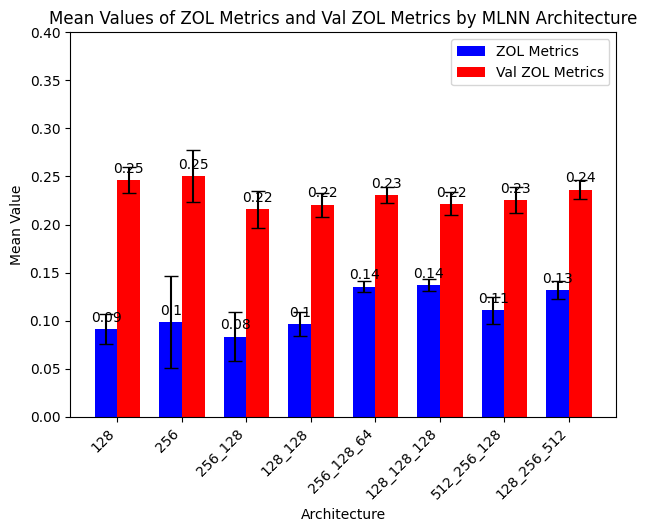

In [ ]:
train_size = int(len(X_train)*4/5)
val_size = int(len(X_train)/5)

plot_zol_histogram("zol_metrics", train_size, val_size)

## Hyperparameters Tuning

In [ ]:
# Values chosen for hyperparameters tuning
learning_rate = [0.01, 0.1] #, 0.001,
dropout_rate = [ 0.4, 0.1, 0.2]

In [ ]:
input_size = (128, 128)
num_classes = 2
hidden_activation = 'relu'
output_activation = 'sigmoid'
n_channels = 3
loss = BinaryCrossentropy()
metrics = [BinaryAccuracy()]

for lr in learning_rate:
    for dr in dropout_rate:
        zol = []
        val_zol = []
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"Training on fold {fold_idx + 1}/{n_folds}...")

            # Prepare the data for this fold
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

            input_size = (128, 128)
            num_classes = 2
            hidden_activation = 'relu'
            output_activation = 'sigmoid'
            n_channels = 3
            loss = BinaryCrossentropy()
            metrics = [BinaryAccuracy()]

            model = MLNN_model(input_size=input_size,
                               num_classes=num_classes,
                               hidden_layer_units=[512, 256, 128],
                               hidden_activation=hidden_activation,
                               output_activation=output_activation,
                               dropout_perc=dr,
                               n_channels=n_channels,
                               loss=loss,
                               learning_rate = lr,
                               metrics=metrics)

            # Train the model
            model.fit(X_train_fold, Y_train_fold, batch_size=32, epochs=15, validation_data=(X_val_fold, Y_val_fold), verbose=1)

            # Calculate zero-one loss for the training fold
            y_train_pred = model.predict(X_train_fold)
            y_train_pred_classes = np.round(y_train_pred)
            train_zero_one_loss = zero_one_loss(Y_train_fold, y_train_pred_classes)
            zol.append(train_zero_one_loss)

            # Calculate zero-one loss for the validation fold
            y_val_pred = model.predict(X_val_fold)
            y_val_pred_classes = np.round(y_val_pred)
            val_zero_one_loss = zero_one_loss(Y_val_fold, y_val_pred_classes)
            val_zol.append(val_zero_one_loss)

        print(f"{lr}, {dr} -> zol: {zol}, val_zol:{val_zol}")

Training on fold 1/5...
Epoch 1/15
130/130 [==============================] - 8s 17ms/step - loss: 0.6649 - binary_accuracy: 0.6399 - val_loss: 0.6209 - val_binary_accuracy: 0.6425
Epoch 2/15
130/130 [==============================] - 2s 15ms/step - loss: 0.6036 - binary_accuracy: 0.6780 - val_loss: 0.5602 - val_binary_accuracy: 0.7130
Epoch 3/15
130/130 [==============================] - 2s 17ms/step - loss: 0.5443 - binary_accuracy: 0.7280 - val_loss: 0.5211 - val_binary_accuracy: 0.7459
Epoch 4/15
130/130 [==============================] - 2s 14ms/step - loss: 0.5314 - binary_accuracy: 0.7326 - val_loss: 0.5317 - val_binary_accuracy: 0.7198
Epoch 5/15
130/130 [==============================] - 2s 14ms/step - loss: 0.5128 - binary_accuracy: 0.7582 - val_loss: 0.4893 - val_binary_accuracy: 0.7633
Epoch 6/15
130/130 [==============================] - 2s 14ms/step - loss: 0.4786 - binary_accuracy: 0.7790 - val_loss: 0.4921 - val_binary_accuracy: 0.7691
Epoch 7/15
130/130 [==============

## Final Training and Testing MLNN

In [ ]:
input_size = (128, 128)
num_classes = 2
hidden_activation = 'relu'
output_activation = 'sigmoid'
dropout_perc = 0.4
n_channels = 3
loss = BinaryCrossentropy()
learning_rate = 0.01
metrics = [BinaryAccuracy(), Precision(), Recall(), AUC()]

histories = []
scores = []
datasets = ["RGB", "RGB_AUGMENTED", "RGB_SEGMENTED"]

In [ ]:
for name in datasets:
    input_dir = f"{DATASET_NAME}/{MODIFIED}/{name}"
    print(f"{DATASET_NAME}/{MODIFIED}/{name}:")

    X, Y = load_dataset(input_dir)

    # random state = SEED to control the reproducibility of the shuffling
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)


    model = MLNN_model(input_size=input_size,
                                num_classes=num_classes,
                                hidden_layer_units=[512, 256, 128],
                                hidden_activation=hidden_activation,
                                output_activation=output_activation,
                                dropout_perc=dropout_perc,
                                n_channels=n_channels,
                                loss=loss,
                                metrics=metrics)

    # Train the model
    history = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

    # Definition of the path to the models directory
    directory = '/models'

    # Checks if the directory exists, if it doesn't it creates it.
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the model in the 'models' directory
    model_path = os.path.join(directory, f'{name}_MLNNmodel.h5')
    model.save(model_path)

    scores = model.evaluate(X_test, Y_test)
    print(f"{name}: loss = {scores[0]}, Binary accuracy = {scores[1]}, Precision = {scores[2]}, Recall = {scores[3]}, AUC = {scores[4]}")

muffin-vs-chihuahua-image-classification/MODIFIED_DATASETS/RGB:
Epoch 1/15
162/162 [==============================] - 11s 13ms/step - loss: 0.6546 - binary_accuracy: 0.6354 - precision_1: 0.6038 - recall_1: 0.5469 - auc_1: 0.6857
Epoch 2/15
162/162 [==============================] - 2s 13ms/step - loss: 0.5889 - binary_accuracy: 0.6972 - precision_1: 0.6763 - recall_1: 0.6248 - auc_1: 0.7598
Epoch 3/15
162/162 [==============================] - 2s 13ms/step - loss: 0.5359 - binary_accuracy: 0.7244 - precision_1: 0.7048 - recall_1: 0.6648 - auc_1: 0.8034
Epoch 4/15
162/162 [==============================] - 2s 13ms/step - loss: 0.5069 - binary_accuracy: 0.7414 - precision_1: 0.7280 - recall_1: 0.6773 - auc_1: 0.8255
Epoch 5/15
162/162 [==============================] - 2s 14ms/step - loss: 0.4912 - binary_accuracy: 0.7720 - precision_1: 0.7636 - recall_1: 0.7130 - auc_1: 0.8435
Epoch 6/15
162/162 [==============================] - 3s 16ms/step - loss: 0.4732 - binary_accuracy: 0.7751 - 

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 rescaling_2 (Rescaling)     (None, 49152)             0         
                                                                 
 batch_normalization_6 (Bat  (None, 49152)             196608    
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 49152)             0         
                                                                 
 dropout_6 (Dropout)         (None, 49152)             0         
                                                           

# CNN

## Definition of functions


In [ ]:
def CNN_model(input_size: tuple = (128, 128),
              n_channels: int = 3,
              conv_filters: list = [32, 64, 128],
              kernel_size: tuple = (3, 3),
              pool_size: tuple = (2, 2),
              dense_units: int = 128,
              output_activation: str = 'sigmoid',
              loss: str = 'binary_crossentropy',
              learning_rate : float = 0.001,
              metrics: list = [
                  BinaryAccuracy(),
                  Precision(),
                  Recall(),
                  AUC()
              ]):

    """
    This function builds and compiles a Convolutional Neural Network (CNN) for binary classification.

    Parameters:
        - input_size: the dimensions of the input images (height, width);
        - n_channels: the number of color channels in the input images (e.g., 3 for RGB);
        - conv_filters: a list containing the number of filters for each convolutional layer;
        - kernel_size: the size of the convolutional kernels;
        - pool_size: the size of the pooling windows;
        - dense_units: the number of units in the dense layer;
        - output_activation: the activation function of the output layer;
        - optimizer: the optimizer to use for compiling the model;
        - loss: the loss function to use for compiling the model;
        - metrics: the list of metrics used to evaluate the performance of the model;

    Returns:
        - model: the compiled CNN model.
    """

    model = models.Sequential()

    # Add convolutional and max pooling layers
    for filters in conv_filters:
        if len(model.layers) == 0:
            # First layer includes the input shape
            model.add(Rescaling(1./255))
            model.add(layers.Conv2D(filters, kernel_size, activation='relu', input_shape=(input_size[0], input_size[1], n_channels)))

        else:
            model.add(layers.Conv2D(filters, kernel_size, activation='relu'))
        model.add(layers.MaxPooling2D(pool_size))

    # Flatten the output and add the dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))

    # Add the output layer
    model.add(layers.Dense(1, activation=output_activation))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate = learning_rate),
                  loss=loss,
                  metrics=metrics)

    return model

In [ ]:
def plot_metrics(history,
                 metric: str,
                 arch: str
                 ):

    """
    Plot the training metrics.

    Parameters:
        - history: dictionary containing the metrics for each epoch;
        - metric: the metric to plot;
        - arch: the name of the architecture.

    Returns:
        - None.
    """

    plt.figure(figsize=(12, 8))

    # Retrieve the metric values
    metric_values = history[metric]

    # Plot the metrics
    plt.plot(metric_values, label=f'Training {metric}', linestyle='-')

    plt.title(f'{metric} for {arch}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{metric} for {arch}.png")
    plt.show()

## Hyperparameters Tuning

In [ ]:
learning_rate = [0.001] #, 0.01, 0.1]
kernel_size = [(3, 3)] #, (5, 5)]

In [ ]:
for ks in kernel_size:
    for lr in learning_rate:
        zol = []
        val_zol = []
        input_dir = f"{DATASET_NAME}/{MODIFIED}/RGB"
        X, Y = load_dataset(input_dir)

        # random state = SEED to control the reproducibility of the shuffling
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)

        kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"Training on fold {fold_idx + 1}/{n_folds}...")

            # Prepare the data for this fold
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]


            model = CNN_model(learning_rate = lr, kernel_size = ks)

            # Train the model
            model.fit(X_train_fold, Y_train_fold, batch_size=32, epochs=15, validation_data=(X_val_fold, Y_val_fold), verbose=1)

            # Calculate zero-one loss for the training fold
            y_train_pred = model.predict(X_train_fold)
            y_train_pred_classes = np.round(y_train_pred)
            train_zero_one_loss = zero_one_loss(Y_train_fold, y_train_pred_classes)
            zol.append(train_zero_one_loss)

            # Calculate zero-one loss for the validation fold
            y_val_pred = model.predict(X_val_fold)
            y_val_pred_classes = np.round(y_val_pred)
            val_zero_one_loss = zero_one_loss(Y_val_fold, y_val_pred_classes)
            val_zol.append(val_zero_one_loss)

        print(f"{ks}, {lr} -> zol: {zol}, val_zol:{val_zol}")

Training on fold 1/5...
Epoch 1/15
130/130 [==============================] - 5s 21ms/step - loss: 0.6259 - binary_accuracy: 0.6657 - precision_2: 0.6569 - recall_2: 0.5230 - auc_2: 0.7110 - val_loss: 0.4781 - val_binary_accuracy: 0.7797 - val_precision_2: 0.7846 - val_recall_2: 0.7223 - val_auc_2: 0.8591
Epoch 2/15
130/130 [==============================] - 2s 19ms/step - loss: 0.4134 - binary_accuracy: 0.8121 - precision_2: 0.7930 - recall_2: 0.7827 - auc_2: 0.8918 - val_loss: 0.3810 - val_binary_accuracy: 0.8309 - val_precision_2: 0.8781 - val_recall_2: 0.7370 - val_auc_2: 0.9212
Epoch 3/15
130/130 [==============================] - 2s 19ms/step - loss: 0.3397 - binary_accuracy: 0.8536 - precision_2: 0.8421 - recall_2: 0.8266 - auc_2: 0.9288 - val_loss: 0.3260 - val_binary_accuracy: 0.8676 - val_precision_2: 0.9385 - val_recall_2: 0.7641 - val_auc_2: 0.9489
Epoch 4/15
130/130 [==============================] - 3s 21ms/step - loss: 0.2729 - binary_accuracy: 0.8850 - precision_2: 0.87

## Final Training and Testing CNN

In [ ]:
learning_rate = 0.001
kernel_size = (3, 3)

histories = []
scores = []
datasets = ["RGB", "RGB_AUGMENTED", "RGB_SEGMENTED"]

In [ ]:
for name in datasets:
    input_dir = f"{DATASET_NAME}/{MODIFIED}/{name}"
    print(f"{DATASET_NAME}/{MODIFIED}/{name}:")

    X, Y = load_dataset(input_dir)

    # random state = SEED to control the reproducibility of the shuffling
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)

    model = CNN_model()
    # Train the model
    history = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

    # Definition of the path to the models directory
    directory = '/models'

    # Checks if the directory exists, if it doesn't it creates it.
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the model in the 'models' directory
    model_path = os.path.join(directory, f'{name}_CNNmodel.h5')
    model.save(model_path)

    scores = model.evaluate(X_test, Y_test)
    print(f"{name}: loss = {scores[0]}, Binary accuracy = {scores[1]}, Precision = {scores[2]}, Recall = {scores[3]}, AUC = {scores[4]}")

muffin-vs-chihuahua-image-classification/MODIFIED_DATASETS/RGB:
Epoch 1/15
162/162 [==============================] - 8s 19ms/step - loss: 0.4964 - binary_accuracy: 0.7556 - precision_2: 0.7264 - recall_2: 0.7311 - auc_2: 0.8378
Epoch 2/15
162/162 [==============================] - 3s 16ms/step - loss: 0.3624 - binary_accuracy: 0.8458 - precision_2: 0.8312 - recall_2: 0.8240 - auc_2: 0.9178
Epoch 3/15
162/162 [==============================] - 3s 21ms/step - loss: 0.2897 - binary_accuracy: 0.8835 - precision_2: 0.8714 - recall_2: 0.8688 - auc_2: 0.9479
Epoch 4/15
162/162 [==============================] - 3s 21ms/step - loss: 0.2402 - binary_accuracy: 0.8986 - precision_2: 0.8882 - recall_2: 0.8855 - auc_2: 0.9645
Epoch 5/15
162/162 [==============================] - 3s 16ms/step - loss: 0.1751 - binary_accuracy: 0.9335 - precision_2: 0.9275 - recall_2: 0.9243 - auc_2: 0.9807
Epoch 6/15
162/162 [==============================] - 3s 16ms/step - loss: 0.1404 - binary_accuracy: 0.9480 - p

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)      

# TogNet

In [ ]:
def TogNet_model(input_size: tuple = (128, 128),
              n_channels: int = 3,
              conv_filters: list = [32, 64, 64],
              kernel_size: tuple = (3, 3),
              pool_size: tuple = (2, 2),
              dense_units: int = 128,
              hidden_activation: str = "relu",
              output_activation: str = "sigmoid",
              loss: str = "binary_crossentropy",
              learning_rate: float = 0.001,
              dropout_rate: float = 0.2,
              metrics: list = [
                  BinaryAccuracy(),
                  Precision(),
                  Recall(),
                  AUC()
              ]):

    """
    This function builds and compiles a Convolutional Neural Network (CNN) for binary classification.

    Parameters:
        - input_size: the dimensions of the input images;
        - n_channels: the number of color channels in the input images (e.g., 3 for RGB);
        - conv_filters: a list containing the number of filters for each convolutional layer;
        - kernel_size: the size of the convolutional kernels;
        - pool_size: the size of the pooling windows;
        - dense_units: the number of units in the dense layer;
        - hidden_activation: the activation function of the hidde layers;
        - output_activation: the activation function of the output layer;
        - optimizer: the optimizer used for compiling the model;
        - loss: the loss function used for compiling the model;
        - dropout_rate: the rate for dropout layers to avoid overfitting;
        - metrics: the list of metrics used to evaluate the performance of the model;

    Returns:
        - model: the compiled CNN model.
    """
    model = models.Sequential()

    # Add convolutional and max pooling layers
    for filters in conv_filters:
        if len(model.layers) == 0:
            # First layer includes the input shape
            model.add(Rescaling(1./255))
            model.add(layers.Conv2D(filters, kernel_size, activation=hidden_activation, input_shape=(input_size[0], input_size[1], n_channels)))

        else:
            model.add(layers.Conv2D(filters, kernel_size, activation=hidden_activation))
        model.add(layers.MaxPooling2D(pool_size))
        model.add(layers.Dropout(dropout_rate))

    # Flatten the output and add the dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=hidden_activation))
    model.add(layers.Dropout(dropout_rate))

    # Add the output layer
    model.add(layers.Dense(1, activation=output_activation))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate = learning_rate),
                  loss=loss,
                  metrics=metrics)

    return model

## Hyperparameters Tuning



In [ ]:
dropout_rate = [0.5] # [0.1, 0.2, 0.4]

Training on fold 1/5...
Epoch 1/15
130/130 [==============================] - 15s 33ms/step - loss: 0.6335 - binary_accuracy: 0.6418 - precision_1: 0.6175 - recall_1: 0.5154 - auc_1: 0.6999 - val_loss: 0.5595 - val_binary_accuracy: 0.7498 - val_precision_1: 0.6797 - val_recall_1: 0.8685 - val_auc_1: 0.8566
Epoch 2/15
130/130 [==============================] - 3s 23ms/step - loss: 0.4703 - binary_accuracy: 0.7879 - precision_1: 0.7606 - recall_1: 0.7648 - auc_1: 0.8606 - val_loss: 0.4211 - val_binary_accuracy: 0.8116 - val_precision_1: 0.8087 - val_recall_1: 0.7766 - val_auc_1: 0.8974
Epoch 3/15
130/130 [==============================] - 3s 22ms/step - loss: 0.3963 - binary_accuracy: 0.8261 - precision_1: 0.8016 - recall_1: 0.8103 - auc_1: 0.9012 - val_loss: 0.3592 - val_binary_accuracy: 0.8638 - val_precision_1: 0.8225 - val_recall_1: 0.8998 - val_auc_1: 0.9367
Epoch 4/15
130/130 [==============================] - 3s 24ms/step - loss: 0.3744 - binary_accuracy: 0.8399 - precision_1: 0.8

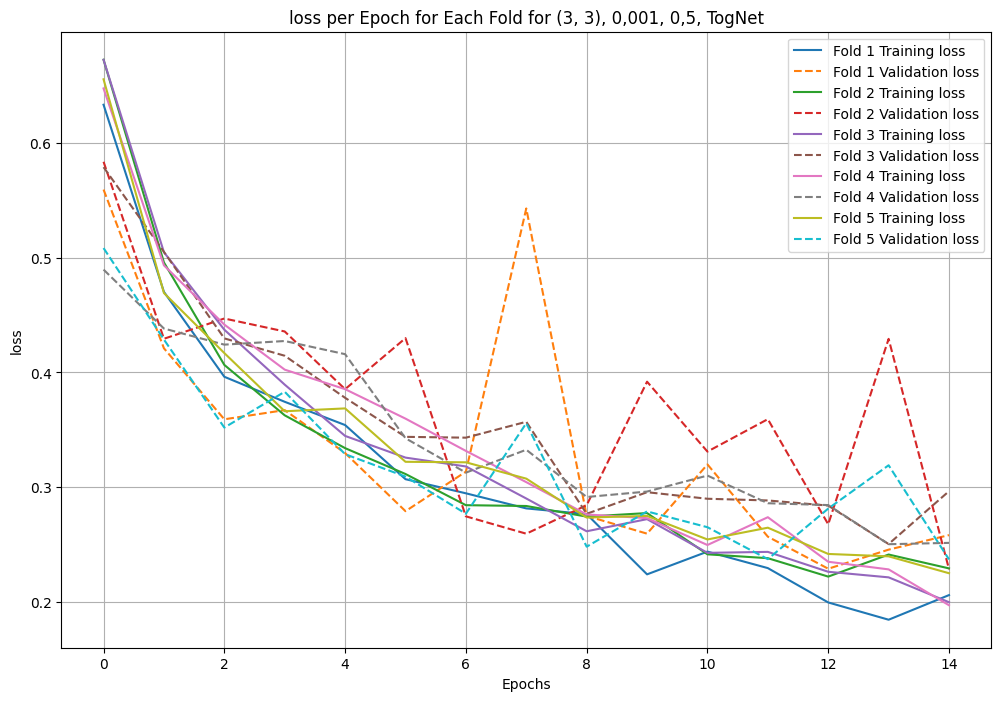

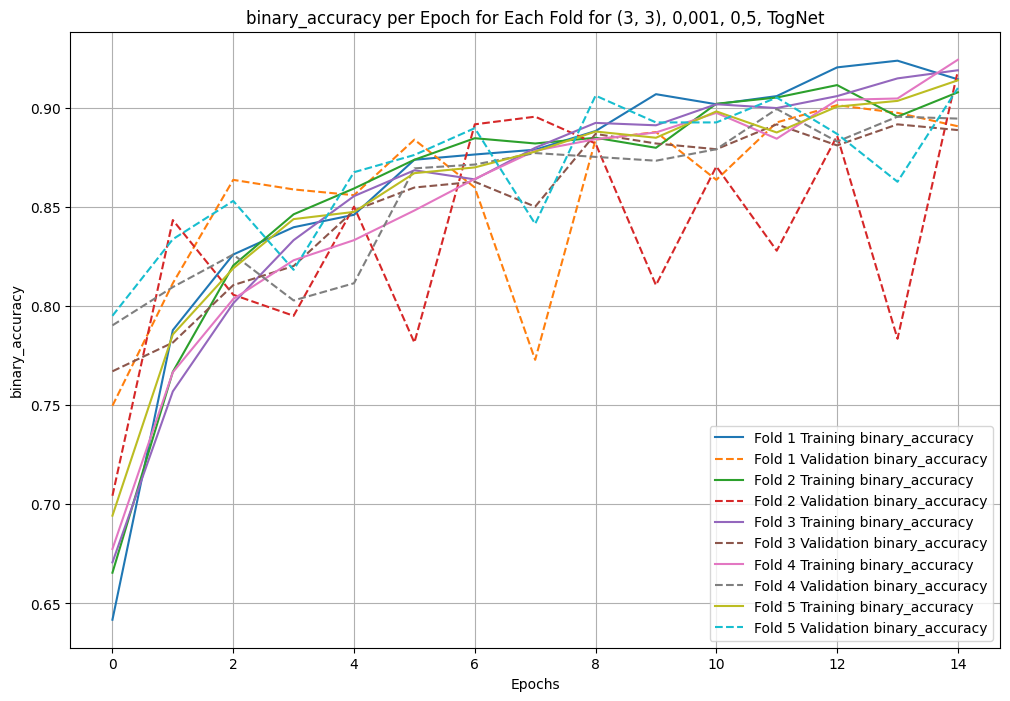

In [ ]:
for ks in kernel_size:
    for lr in learning_rate:
            for dr in dropout_rate:
                scores = []
                zol = []
                val_zol = []
                input_dir = f"{DATASET_NAME}/{MODIFIED}/RGB"
                X, Y = load_dataset(input_dir)

                # random state = SEED to control the reproducibility of the shuffling
                X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)

                kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

                for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                    print(f"Training on fold {fold_idx + 1}/{n_folds}...")

                    # Prepare the data for this fold
                    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

                    model = TogNet_model(learning_rate = lr, kernel_size = ks, dropout_rate = dr)

                    # Train the model
                    history = model.fit(X_train_fold, Y_train_fold, batch_size=32, epochs=15, validation_data=(X_val_fold, Y_val_fold), verbose=1)
                    scores.append(history.history)

                    # Calculate zero-one loss for the training fold
                    y_train_pred = model.predict(X_train_fold)
                    y_train_pred_classes = np.round(y_train_pred)
                    train_zero_one_loss = zero_one_loss(Y_train_fold, y_train_pred_classes)
                    zol.append(train_zero_one_loss)

                    # Calculate zero-one loss for the validation fold
                    y_val_pred = model.predict(X_val_fold)
                    y_val_pred_classes = np.round(y_val_pred)
                    val_zero_one_loss = zero_one_loss(Y_val_fold, y_val_pred_classes)
                    val_zol.append(val_zero_one_loss)

                print(f"{ks}, {lr} -> zol: {zol}, val_zol:{val_zol}")
                plot_kfold_metrics(scores, "loss", f"{ks}, {str(lr).replace('.', ',')}, {str(dr).replace('.', ',')}, TogNet")
                plot_kfold_metrics(scores, "binary_accuracy", f"{ks}, {str(lr).replace('.', ',')}, {str(dr).replace('.', ',')}, TogNet")

## Final Training and Testing


In [ ]:
dropout_rate = 0.4

histories = []
scores = []
datasets = ["RGB" , "RGB_AUGMENTED", "RGB_SEGMENTED"]

In [ ]:
for name in datasets:
    input_dir = f"{DATASET_NAME}/{MODIFIED}/{name}"
    print(f"{DATASET_NAME}/{MODIFIED}/{name}:")

    X, Y = load_dataset(input_dir)

    # random state = SEED to control the reproducibility of the shuffling
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = SEED)

    model = TogNet_model(dropout_rate = dropout_rate)
    # Train the model
    history = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

    # Definition of the path to the models directory
    directory = '/models'

    # Checks if the directory exists, if it doesn't it creates it.
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the model in the 'models' directory
    model_path = os.path.join(directory, f'{name}_TogNetmodel.h5')
    model.save(model_path)

    scores = model.evaluate(X_test, Y_test)
    print(f"{name}: loss = {scores[0]}, Binary accuracy = {scores[1]}, Precision = {scores[2]}, Recall = {scores[3]}, AUC = {scores[4]}")

muffin-vs-chihuahua-image-classification/MODIFIED_DATASETS/RGB:
Epoch 1/15
162/162 [==============================] - 6s 23ms/step - loss: 0.6125 - binary_accuracy: 0.6649 - precision_4: 0.6773 - recall_4: 0.4849 - auc_4: 0.7304
Epoch 2/15
162/162 [==============================] - 3s 20ms/step - loss: 0.4576 - binary_accuracy: 0.7950 - precision_4: 0.7684 - recall_4: 0.7780 - auc_4: 0.8678
Epoch 3/15
162/162 [==============================] - 3s 20ms/step - loss: 0.3990 - binary_accuracy: 0.8261 - precision_4: 0.8022 - recall_4: 0.8133 - auc_4: 0.9007
Epoch 4/15
162/162 [==============================] - 3s 20ms/step - loss: 0.3329 - binary_accuracy: 0.8647 - precision_4: 0.8491 - recall_4: 0.8498 - auc_4: 0.9314
Epoch 5/15
162/162 [==============================] - 3s 22ms/step - loss: 0.3113 - binary_accuracy: 0.8692 - precision_4: 0.8570 - recall_4: 0.8507 - auc_4: 0.9401
Epoch 6/15
162/162 [==============================] - 3s 20ms/step - loss: 0.2808 - binary_accuracy: 0.8854 - p

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                